# Recurrent neural networks

# Task 1

Get IBM stock market data and evaluate prediction on a set of recurrent neural networks.

Dataset can be downloaded from https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231



## Subtask 1

Load data and prepare the dataset

In [274]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,Flatten,InputLayer,SimpleRNN
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [275]:
# Write your code here
import pandas as pd
import numpy as np
import tensorflow as tf


data = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
data.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


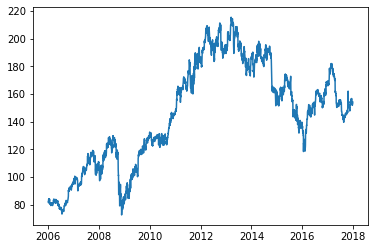

In [276]:
import matplotlib.pyplot as plt

plt.plot(data.index,data['Open'])
plt.show()

In [277]:
# train and test split

# train data
close_prices = data['Close']
training_set = close_prices[:'2016']
test_set = close_prices['2017':]
# print(len(training_set))
# print(len(test_set))

#Min-Max Scaling for the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(training_set.values.reshape(-1,1))
scaled_data.shape

(2769, 1)

In [278]:
# sliding window
window_size = 20

x_train = []
y_train = []

# Sliding window
for i in range(window_size, len(scaled_data)):      
    x_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])                     

    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape,y_train.shape)

(2749, 20, 1) (2749,)


In [279]:
# test data
actual_values = test_set.values
total_dataset = pd.concat((training_set, test_set), axis=0)
len_train_data = len(total_dataset)-len(test_set)

x_test = []
y_test = []

y_test = total_dataset[len_train_data-window_size:].values
y_test = y_test.reshape(-1,1)

y_test = scaler.transform(y_test)
# y_test.shape


for i in range(window_size, len(y_test)):
  x_test.append(y_test[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape,y_test.shape)

(251, 20, 1) (271, 1)


# Subtask 2

Perform prediction by using feed-forward neural network (sliding window)

In [295]:
# Feed Forward Neural network 


model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1],1)))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="linear"))
model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 20)                0         
                                                                 
 dense_108 (Dense)           (None, 16)                336       
                                                                 
 dense_109 (Dense)           (None, 1)                 17        
                                                                 
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [296]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics="mse")
FFNhist = model.fit(x_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
43/43 [==============================] - 0s 2ms/step - loss: 0.1474 - mse: 0.1474
Epoch 2/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0033 - mse: 0.0033
Epoch 3/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 4/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0025 - mse: 0.0025
Epoch 5/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 6/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 7/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0021 - mse: 0.0021
Epoch 8/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020
Epoch 9/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019
Epoch 10/20
43/43 [==============================] - 0s 2ms/step - loss: 0.0019 - mse: 0.0019
Epoch 11/20
43/43 [==============================] - 0s 2ms/step - lo

In [297]:
FFNpredictions = model.predict(x_test)
FFNpredictions = scaler.inverse_transform(FFNpredictions)
FFNmse = mean_squared_error(test_set,FFNpredictions.flatten())
print("FFN-mse :",FFNmse)

8/8 [==============================] - 0s 2ms/step
FFN-mse : 12.658755852160558


In [298]:
# len(FFNpredictions)
# actual_values[:len(FFNpredictions)]

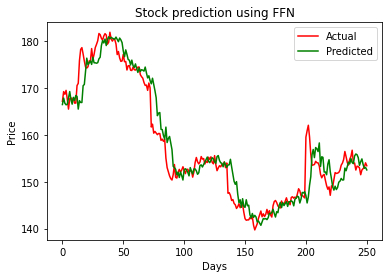

In [299]:
plt.plot(actual_values, color='red', label=f"Actual")
plt.plot(FFNpredictions, color= 'green', label="Predicted")
plt.title("Stock prediction using FFN")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

## Subtask 3

Perform prediction by using RNN

In [303]:
# RNN model
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(units=32, input_shape=(x_train.shape[1],1), activation='tanh'))
RNNmodel.add(Dense(units=8, activation='tanh'))
RNNmodel.add(Dense(units=1, activation='linear'))
RNNmodel.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_15 (SimpleRNN)   (None, 32)                1088      
                                                                 
 dense_112 (Dense)           (None, 8)                 264       
                                                                 
 dense_113 (Dense)           (None, 1)                 9         
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [304]:
RNNmodel.compile(optimizer='adam', loss='mean_squared_error', metrics="mse")
RNNhist = RNNmodel.fit(x_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
43/43 [==============================] - 1s 6ms/step - loss: 0.0678 - mse: 0.0678
Epoch 2/20
43/43 [==============================] - 0s 5ms/step - loss: 0.0025 - mse: 0.0025
Epoch 3/20
43/43 [==============================] - 0s 5ms/step - loss: 0.0017 - mse: 0.0017
Epoch 4/20
43/43 [==============================] - 0s 6ms/step - loss: 0.0014 - mse: 0.0014
Epoch 5/20
43/43 [==============================] - 0s 5ms/step - loss: 0.0013 - mse: 0.0013
Epoch 6/20
43/43 [==============================] - 0s 5ms/step - loss: 0.0011 - mse: 0.0011
Epoch 7/20
43/43 [==============================] - 0s 5ms/step - loss: 0.0010 - mse: 0.0010
Epoch 8/20
43/43 [==============================] - 0s 5ms/step - loss: 9.3683e-04 - mse: 9.3683e-04
Epoch 9/20
43/43 [==============================] - 0s 6ms/step - loss: 8.2568e-04 - mse: 8.2568e-04
Epoch 10/20
43/43 [==============================] - 0s 5ms/step - loss: 7.7400e-04 - mse: 7.7400e-04
Epoch 11/20
43/43 [==========================

In [305]:
RNNpredictions = RNNmodel.predict(x_test)
RNNpredictions = scaler.inverse_transform(RNNpredictions)
RNNmse = mean_squared_error(test_set,RNNpredictions.flatten())
print("RNN-mse :",RNNmse)

8/8 [==============================] - 0s 3ms/step
RNN-mse : 6.167714021933142


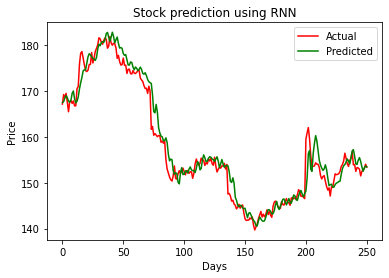

In [306]:
plt.plot(actual_values, color='red', label=f"Actual")
plt.plot(RNNpredictions, color= 'green', label="Predicted")
plt.title("Stock prediction using RNN")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

## Subtask 4

Perform prediction by using LSTM

In [307]:
# Write your code here
LSTMmodel = Sequential()
LSTMmodel.add(InputLayer(input_shape=(x_train.shape[1], 1)))
LSTMmodel.add(LSTM(100, return_sequences=False))
LSTMmodel.add(Dense(50))
LSTMmodel.add(Dense(1))
LSTMmodel.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 100)               40800     
                                                                 
 dense_114 (Dense)           (None, 50)                5050      
                                                                 
 dense_115 (Dense)           (None, 1)                 51        
                                                                 
Total params: 45,901
Trainable params: 45,901
Non-trainable params: 0
_________________________________________________________________


In [308]:
LSTMmodel.compile(optimizer='adam',loss='mean_squared_error', metrics="mse")
LSTMhist = LSTMmodel.fit(x_train, y_train, batch_size= 64, epochs=20)

Epoch 1/20
43/43 [==============================] - 4s 28ms/step - loss: 0.0264 - mse: 0.0264
Epoch 2/20
43/43 [==============================] - 1s 28ms/step - loss: 6.9972e-04 - mse: 6.9972e-04
Epoch 3/20
43/43 [==============================] - 1s 29ms/step - loss: 4.5620e-04 - mse: 4.5620e-04
Epoch 4/20
43/43 [==============================] - 1s 28ms/step - loss: 4.5123e-04 - mse: 4.5123e-04
Epoch 5/20
43/43 [==============================] - 1s 27ms/step - loss: 4.3951e-04 - mse: 4.3951e-04
Epoch 6/20
43/43 [==============================] - 1s 28ms/step - loss: 4.3540e-04 - mse: 4.3540e-04
Epoch 7/20
43/43 [==============================] - 1s 28ms/step - loss: 4.2884e-04 - mse: 4.2884e-04
Epoch 8/20
43/43 [==============================] - 1s 28ms/step - loss: 4.2329e-04 - mse: 4.2329e-04
Epoch 9/20
43/43 [==============================] - 1s 28ms/step - loss: 4.1525e-04 - mse: 4.1525e-04
Epoch 10/20
43/43 [==============================] - 1s 28ms/step - loss: 4.0915e-04 - mse

In [309]:
LSTMpredictions = LSTMmodel.predict(x_test)
LSTMpredictions = scaler.inverse_transform(LSTMpredictions)
LSTMmse = mean_squared_error(test_set,LSTMpredictions.flatten())
print("LSTM-mse :",LSTMmse)

8/8 [==============================] - 1s 6ms/step
LSTM-mse : 4.951494909505503


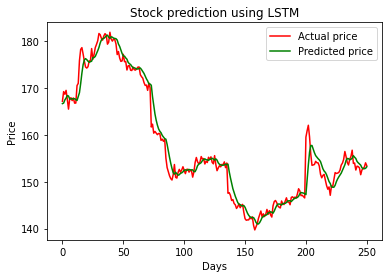

In [310]:
plt.plot(actual_values, color='red', label=f"Actual price")
plt.plot(LSTMpredictions, color= 'green', label="Predicted price")
plt.title("Stock prediction using LSTM")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

## Subtask 5

Compare all above results by using MSE error and dermine the best architecture. You can do tests on more stock data than IBM.

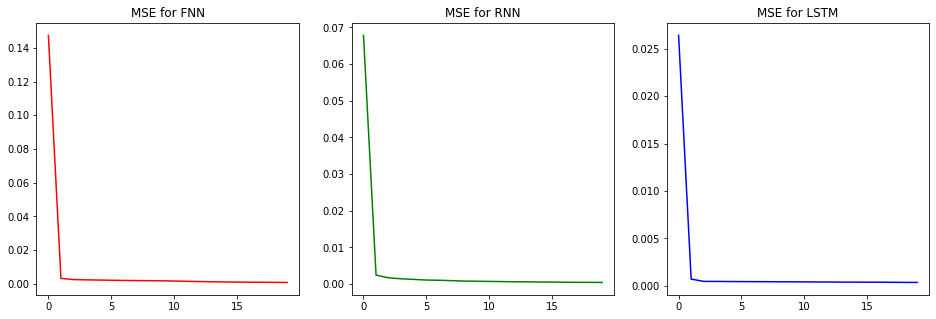

In [311]:
# comparing results using MSE error
fig, ax = plt.subplots(ncols=3, figsize=(16, 5))
ax[0].plot(FFNhist.history["mse"], color="red")
ax[0].set_title("MSE for FNN")
ax[1].plot(RNNhist.history["mse"],color="green")
ax[1].set_title("MSE for RNN")
ax[2].plot(LSTMhist.history["mse"],color="blue")
ax[2].set_title("MSE for LSTM")

plt.show()


In [312]:
print("FFN-MSE:",FFNmse)
print("RNN-MSE:",RNNmse)
print("LSTM-mse:",LSTMmse)

FFN-MSE: 12.658755852160558
RNN-MSE: 6.167714021933142
LSTM-mse: 4.951494909505503


In [313]:
print("By the above comparision we can clearly observe that LSTM model has the better MSE value")

By the above comparision we can clearly observe that LSTM model has the better MSE value
